# Use Machine Learning in a Trading Strategy

## Loading and Preparing the Data

In [50]:
# Import required libraries
import pandas as pd
from pathlib import Path

In [51]:
# Import the OHLCV dataset into a Pandas Dataframe
trading_df = pd.read_csv(
    Path("Resources/Week15-Day3-Activity6-ohlcv.csv"), 
    index_col="date", 
    infer_datetime_format=True, 
    parse_dates=True
)

# Display sample data
trading_df.head()

,open,high,low,close,volume
date,,,,,
2018-10-19 09:30:00,16.90,17.18,16.90,17.095,11522
2018-10-19 09:45:00,17.11,17.44,17.11,17.400,70593
2018-10-19 10:00:00,17.40,17.40,17.25,17.280,38885
2018-10-19 10:15:00,17.27,17.27,17.18,17.200,37046
2018-10-19 10:30:00,17.21,17.37,17.19,17.200,46874


In [52]:
# Calculate the daily returns using the closing prices and the pct_change function
trading_df["actual_returns"] = trading_df["close"].pct_change()

# Display sample data
trading_df.head()

,open,high,low,close,volume,actual_returns
date,,,,,,
2018-10-19 09:30:00,16.90,17.18,16.90,17.095,11522,NaN
2018-10-19 09:45:00,17.11,17.44,17.11,17.400,70593,0.017841
2018-10-19 10:00:00,17.40,17.40,17.25,17.280,38885,-0.006897
2018-10-19 10:15:00,17.27,17.27,17.18,17.200,37046,-0.004630
2018-10-19 10:30:00,17.21,17.37,17.19,17.200,46874,0.000000


In [53]:
# Drop all NaN values from the DataFrame
trading_df = trading_df.dropna()

# Review the DataFrame
display(trading_df.head())
display(trading_df.tail())

,open,high,low,close,volume,actual_returns
date,,,,,,
2018-10-19 09:45:00,17.11,17.44,17.11,17.40,70593,0.017841
2018-10-19 10:00:00,17.40,17.40,17.25,17.28,38885,-0.006897
2018-10-19 10:15:00,17.27,17.27,17.18,17.20,37046,-0.004630
2018-10-19 10:30:00,17.21,17.37,17.19,17.20,46874,0.000000
2018-10-19 10:45:00,17.20,17.20,17.10,17.12,11266,-0.004651


,open,high,low,close,volume,actual_returns
date,,,,,,
2020-09-04 14:45:00,6.225,6.26,6.220,6.250,55512,0.003210
2020-09-04 15:00:00,6.255,6.27,6.245,6.250,65810,0.000000
2020-09-04 15:15:00,6.250,6.29,6.250,6.275,202630,0.004000
2020-09-04 15:30:00,6.270,6.28,6.250,6.255,130140,-0.003187
2020-09-04 15:45:00,6.250,6.28,6.250,6.250,190278,-0.000799


## Generating the Features and Target Sets

### Creating the Features Set

In [54]:
# Define a window size of 4
short_window = 4

# Create an SMA that uses short_window, and assign it to a new column named “sma_fast”
trading_df["sma_fast"] = trading_df["close"].rolling(window=short_window).mean()

In [55]:
# Define a window size of 100
long_window = 100

# Create an SMA that uses long_window, and assign it to a new columns named “sma_slow”
trading_df["sma_slow"] = trading_df["close"].rolling(window=long_window).mean()

In [56]:
# Drop the NaNs using dropna()
trading_df = trading_df.dropna()

In [57]:
# Assign a copy of the `sma_fast` and `sma_slow` columns to a new DataFrame called `X`
X = trading_df[["sma_fast", "sma_slow"]].shift().dropna().copy()

# Display sample data
display(X.head())
display(X.tail())

,sma_fast,sma_slow
date,,
2018-10-24 15:15:00,15.65250,16.3403
2018-10-24 15:30:00,15.61875,16.3216
2018-10-24 15:45:00,15.55375,16.3029
2018-10-25 09:30:00,15.47625,16.2844
2018-10-25 09:45:00,15.40250,16.2656


,sma_fast,sma_slow
date,,
2020-09-04 14:45:00,6.22625,6.27210
2020-09-04 15:00:00,6.22875,6.27030
2020-09-04 15:15:00,6.23875,6.26985
2020-09-04 15:30:00,6.25125,6.26910
2020-09-04 15:45:00,6.25750,6.26855


### Creating the Target Set

In [58]:
# Create a new column in the `trading_df` called "signal" setting its value to zero.
trading_df["signal"] = 0.0

In [59]:
# Create the signal to buy
trading_df.loc[(trading_df["actual_returns"] >= 0), "signal"] = 1

In [60]:
# Create the signal to sell
trading_df.loc[(trading_df["actual_returns"] < 0), "signal"] = -1

In [61]:
# Copy the new "signal" column to a new Series called `y`.
y = trading_df["signal"].copy()

## Split the Data into Training and Testing Sets

In [62]:
# Import required libraries
from pandas.tseries.offsets import DateOffset

In [63]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)
print(X.index.max())

2018-10-24 15:15:00
2020-09-04 15:45:00


In [64]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=18)

# Display the training end date
print(training_end)

2020-04-24 15:15:00


In [65]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

In [66]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

## Standardize the Data

In [67]:
# Import required libraries
from sklearn.preprocessing import StandardScaler

In [68]:
# Create a StandardScaler instance
scaler = StandardScaler()
 
# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)
 
# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

---

## Using Machine Learning Into a Trading Strategy

In [69]:
# Import the SVM model
from sklearn import svm
#these are the ones that draw lines and classify 
#SVM - Support Virtual Machine 

from sklearn.metrics import classification_report

In [70]:
# Create the classifier model
svm_model = svm.SVC()
 
# Fit the model to the data using X_train_scaled and y_train
# this is where our algorithm =- buy, sell or hold is deciding 
svm_model = svm_model.fit(X_train_scaled, y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = svm_model.predict(X_train_scaled)

# Display the sample predictions
training_signal_predictions[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [71]:
# Evaluate the model using a classification report
training_report = classification_report(y_train, training_signal_predictions)

# Display the report
print(training_report)

              precision    recall  f1-score   support

        -1.0       0.57      0.01      0.02      4500
         1.0       0.53      0.99      0.69      5005

    accuracy                           0.53      9505
   macro avg       0.55      0.50      0.35      9505
weighted avg       0.55      0.53      0.37      9505



### Backtesting a Machine Learning Trading Algorithm

In [72]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = svm_model.predict(X_test_scaled)

In [73]:
# Evaluate the model's ability to predict the trading signal for the testing data
testing_report = classification_report(y_test, testing_signal_predictions)

# Display the report
print(testing_report)

              precision    recall  f1-score   support

        -1.0       0.48      0.45      0.46      1135
         1.0       0.55      0.58      0.57      1329

    accuracy                           0.52      2464
   macro avg       0.52      0.52      0.52      2464
weighted avg       0.52      0.52      0.52      2464



### Visually Compare the Actual and Predicted Returns

In [74]:
# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

predictions_df["predicted_signal"] = testing_signal_predictions

predictions_df["actual_returns"] = trading_df["actual_returns"]

predictions_df["trading_algorithm_returns"] = (
    predictions_df["actual_returns"] * predictions_df["predicted_signal"]
)

# Review the DataFrame
predictions_df.head()

,predicted_signal,actual_returns,trading_algorithm_returns
date,,,
2020-04-24 15:15:00,1.0,-0.012380,-0.012380
2020-04-24 15:30:00,1.0,0.002786,0.002786
2020-04-24 15:45:00,1.0,-0.001389,-0.001389
2020-04-24 16:00:00,1.0,0.002782,0.002782
2020-04-27 09:30:00,1.0,-0.036061,-0.036061


<AxesSubplot:xlabel='date'>

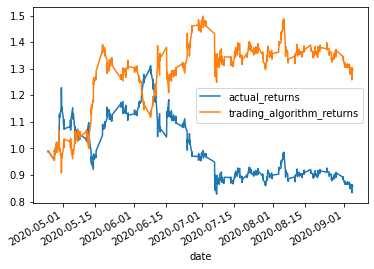

In [75]:
# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()